# What is Dingocar

ToDo

# TDX Dingocar Exploration

The aim of this notebook is to implement the Dingocar self-driving roboar CNN using TFX components.

In [1]:
# TODO(ccy): remove "pyzmq==17.0.0" pin after bug in Colab is fixed.
#!pip install "tfx>=0.21.1,<0.22" "tensorflow>=2.1,<2.2" "tensorboard>=2.1,<2.3" "pyzmq==17.0.0"
!pip install "tfx==0.21.2" "tensorflow>=2.1,<2.2" "tensorboard>=2.1,<2.3" "pyzmq==17.0.0"

     |████████████████████████████████| 1.1MB 12.9MB/s 
     |████████████████████████████████| 421.8MB 41kB/s 
     |████████████████████████████████| 3.1MB 49.0MB/s 
     |████████████████████████████████| 59.2MB 53kB/s 
     |████████████████████████████████| 2.4MB 48.5MB/s 
     |████████████████████████████████| 245kB 40.4MB/s 
     |████████████████████████████████| 3.0MB 44.1MB/s 
     |████████████████████████████████| 276kB 37.1MB/s 
     |████████████████████████████████| 4.9MB 46.7MB/s 
     |████████████████████████████████| 1.5MB 21.3MB/s 
     |████████████████████████████████| 1.9MB 52.1MB/s 
     |████████████████████████████████| 153kB 59.1MB/s 
     |████████████████████████████████| 112kB 60.5MB/s 
     |████████████████████████████████| 450kB 49.0MB/s 
     |████████████████████████████████| 10.4MB 50.8MB/s 
     |████████████████████████████████| 6.7MB 41.3MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 
     |████████████████████████████████| 225kB 57.

**Not sure how many of these we need, will remove undeeded later.**

In [18]:
import os
import pprint
import tempfile
import urllib

import absl
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from tfx.components import CsvExampleGen
from tfx.components import Evaluator
from tfx.components import ExampleValidator
from tfx.components import Pusher
from tfx.components import ResolverNode
from tfx.components import SchemaGen
from tfx.components import StatisticsGen

from tfx.components import Trainer
from tfx.components import Transform
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.proto.evaluator_pb2 import SingleSlicingSpec
from tfx.utils.dsl_utils import external_input
from tfx.types import Channel
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing

%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

The tfx.orchestration.experimental.interactive.notebook_extensions.skip extension is already loaded. To reload it, use:
  %reload_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip


In [2]:
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.1.0
TFX version: 0.21.2


# Download data from public google drive

In [0]:
%%bash
pip install gdown
mkdir data
gdown --id 1gv5k5vK90QOSgenwT42DMm-jmBdB9yEX --output data/tub.zip
(cd data && unzip tub.zip > _ && cd ..)
echo "Number of examples: `ls data/tub/*.jpg | wc -l`"

## Connect to Google Drive

This piece of code will mount the your google drive to this Google Colab virtual machine. It will prompt you to follow a link to get a verification code. Once you get it, copy and paste it in the box provided and hit enter.

You can nevigate the file system by clicking the "Files" tab in the  <-- left side bar. All your google drive files should be in `/content/drive/My\ Drive`

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# MAKE SURE THESE MATCH THE PATH OF THE IMPORTED TUB
from pathlib import Path
_data_root=Path('/content/data/tub/')

_tf_record_dir = Path('/content/data/tf-records')
_tf_record_dir.mkdir(exist_ok=True)

# This is the root directory for your TFX pip package installation.
# _tfx_root = tfx.__path__[0]

# # This is the path where your model will be pushed for serving.
# _serving_model_dir = os.path.join(
#     tempfile.mkdtemp(), 'serving_model/dingo')

# # Set up logging.
# absl.logging.set_verbosity(absl.logging.INFO)

## Import some required modules

In [0]:
%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow
import os
from PIL import Image
from glob import glob
import numpy as np
import json
from tqdm import tqdm

In [0]:
#!wget  https://github.com/tensorflow/tfx/raw/r0.21.1/tfx/examples/cifar10/data/train.tfrecord

In [0]:
# def decode_tfexample(example):
#   print(example)
#   img_string = (example.features.feature['image_raw']
#                                 .bytes_list
#                                 .value)[0]

#   label = (example.features.feature['label']
#                         .int64_list
#                         .value)[0]

#   img_flat = tf.image.decode_jpeg(img_string).numpy()
#   image_arr = img_flat.reshape((32, 32, -1))

#   return image_arr, label

# filenames = ['tfrecords/train.tfrecord']
# raw_dataset = tf.data.TFRecordDataset(filenames)
# for raw_record in raw_dataset.take(1):
#     example = tf.train.Example()
#     example.ParseFromString(raw_record.numpy())
#     image_arr, label = decode_tfexample(example)

# print(f'label: {label}')
# imshow(image_arr)
  

## Load and visualise the data

Donkeycar calls the directory(s) where your training data is stored a "_tub_". The Dingocar follows the same convention.

`Tubs` contain 3 types of files:
- images: in the form of `.jpg`
- records: in the form `.json`
- `meta` which contains some aditional information, also `.json`

Below we set the `tub` location and visualize an image and record

Steering: 0.010503164155113875
Throttle: 1


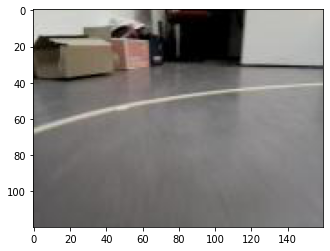

In [7]:
from PIL import Image

label_paths = list(_data_root.glob("record_*.json"))

# Tubs provide a simple way to access the training.
# Each entry is a dict record which contains the 
# a camera image plus the steering and throttle commands
# that were recorded when driving the car manually.
# The dict keys are as follows.
IMAGE_KEY    = "cam/image_array"
STEERING_KEY = "user/angle"
THROTTLE_KEY = "user/throttle"

def read_image(path):
  img = Image.open(path)
  img = np.array(img, dtype=np.uint8)
  return img

def read_label(path):
  with path.open('r') as f:
    label = json.load(f)
  return label

# Read a single label
idx = 123
label = read_label(label_paths[idx])
image_name = label[IMAGE_KEY]
image_path = str(_data_root / image_name)
image = read_image(image_path)

print(f"Steering: {label[STEERING_KEY]}")
print(f"Throttle: {label[THROTTLE_KEY]}")
imshow(image)

# Convert to TF.Example

stuff about serialzation

In [0]:
tfrecords_filename = str(_tf_record_dir / "tf_record.record")
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def read_image_as_byte_string(path):
  # "image/raw" has bytes value "None" which cannot be decoded as a UTF-8 string.
  image_string = open(str(path), 'rb').read()
  return image_string

# Create a dictionary with features
def image_example(record_path, data_dir):
  label = read_label(record_path)
  steering = label[STEERING_KEY]
  throttle = label[THROTTLE_KEY]
  image_name = label[IMAGE_KEY]
  image_path = _data_root / image_name
  image_string = read_image_as_byte_string(image_path)
  image_shape = tf.image.decode_jpeg(image_string).shape

  feature = {
      'image/height': _int64_feature(image_shape[0]),
      'image/width': _int64_feature(image_shape[1]),
      'image/depth': _int64_feature(image_shape[2]),
      'label/steering': _float_feature(steering),
      'label/throttle': _float_feature(throttle),
      'image/raw': _bytes_feature(image_string),
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

with tf.io.TFRecordWriter(tfrecords_filename) as writer:
  for path in label_paths[:10]:
    example = image_example(path, _data_root)
    writer.write(example.SerializeToString())


# Read TFRecord

label: 0.0
throttle: 1.0


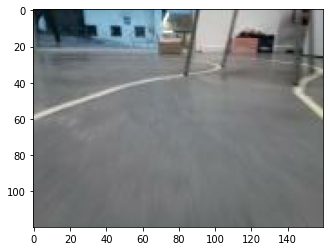

In [9]:
def decode_tfexample(example):

  height = (example.features.feature['image/height']
                                .int64_list
                                .value)[0]
  
  width = (example.features.feature['image/width']
                              .int64_list
                              .value)[0]

  img_string = (example.features.feature['image/raw']
                                .bytes_list
                                .value)[0]
  
  steering = (example.features.feature['label/steering']
                            .float_list
                            .value)[0]

  throttle = (example.features.feature['label/throttle']
                        .float_list
                        .value)[0]

  img_flat = tf.image.decode_jpeg(img_string).numpy()
  image_arr = img_flat.reshape((120, 160, -1))

  return image_arr, (steering, throttle)

filenames = [tfrecords_filename]
raw_dataset = tf.data.TFRecordDataset(filenames)

for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  (image_arr, (steering, throttle)) = decode_tfexample(example)
print(f'label: {steering}')
print(f'throttle: {throttle}')
imshow(image_arr)
  

In [10]:
# Here, we create an InteractiveContext using default parameters. This will
# use a temporary directory with an ephemeral ML Metadata database instance.
# To use your own pipeline root or database, the optional properties
# `pipeline_root` and `metadata_connection_config` may be passed to
# InteractiveContext. Calls to InteractiveContext are no-ops outside of the
# notebook.
context = InteractiveContext()

In [0]:
from tfx.utils.dsl_utils import external_input
from tfx.components.example_gen.import_example_gen.component import ImportExampleGen
from  tfx.proto import example_gen_pb2

examples = external_input(_tf_record_dir)
# https://www.tensorflow.org/tfx/guide/examplegen#custom_inputoutput_split
# has a good explanation of splitting the data the 'output_config' param

# Input train split is _tf_record_dir/*'
# Output 2 splits: train:eval=8:2.

train_ratio = 8
eval_ratio  = 10-train_ratio
output = example_gen_pb2.Output(
             split_config=example_gen_pb2.SplitConfig(splits=[
                 example_gen_pb2.SplitConfig.Split(name='train',
                                                   hash_buckets=train_ratio),
                 example_gen_pb2.SplitConfig.Split(name='eval',
                                                   hash_buckets=eval_ratio)
             ]))
example_gen = ImportExampleGen(input=examples,
                               output_config=output)

In [12]:
context.run(example_gen)

ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(type_name: Examples, uri: /tmp/tfx-interactive-2020-04-10T22_12_50.474774-lt9k73xg/ImportExampleGen/examples/1, id: 2)]
        ))

In [13]:
artifact = example_gen.outputs['examples'].get()[0]
print(artifact.split_names, artifact.uri)

["train", "eval"] /tmp/tfx-interactive-2020-04-10T22_12_50.474774-lt9k73xg/ImportExampleGen/examples/1


features {
  feature {
    key: "image/depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "image/height"
    value {
      int64_list {
        value: 120
      }
    }
  }
  feature {
    key: "image/raw"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\000x\000\240\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221

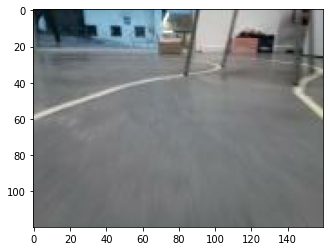

In [16]:
# Get the URI of the output artifact representing the training examples, which is a directory
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Iterate over the first 1 records and decode them.
for tfrecord in dataset.take(1):
  serialized_example = tfrecord.numpy()
  example = tf.train.Example()
  example.ParseFromString(serialized_example)
  pp.pprint(example)

(image_arr, (steering, throttle)) = decode_tfexample(example)
print(f'label: {steering}')
print(f'throttle: {throttle}')
imshow(image_arr)

In [0]:
  # stats_options = StatsOptions(
  #     enable_semantic_domain_stats = True)
  statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples'])

In [20]:
context.run(statistics_gen)

/usr/local/lib/python3.6/dist-packages/tensorflow_data_validation/arrow/arrow_util.py:239: FutureWarning: Calling .data on ChunkedArray is provided for compatibility after Column was removed, simply drop this attribute
  types.FeaturePath([column_name]), column.data.chunk(0), weights):


ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(type_name: ExampleStatistics, uri: /tmp/tfx-interactive-2020-04-10T22_12_50.474774-lt9k73xg/StatisticsGen/statistics/2, id: 3)]
        ))

In [21]:
%%skip_for_export

context.show(statistics_gen.outputs['statistics'])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


This cell will be skipped during export to pipeline.


In [0]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=True)
context.run(schema_gen)

## Data Augmentation

Data augmentation allows us to add a bit more variety to the training data. One very handy augmentation transformation is to randomly mirror the input image and the steering label. This ensurse the data contains the same number or left and right turns so the neural network does not become bias to a specifc direction of turn. 

There are also some other augmentation transformations you can apply below. These will hopefully make the network a bit more robust to canging lighting and help prevent overfitting.

LOADING CONFIG
Steering: 0.2899459995942749
Throttle: 0.9929782956186386


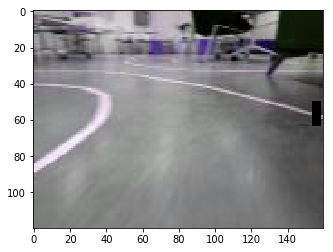

In [0]:
import config
from functools import partial
from dingocar.parts.augmentation import apply_aug_config

# Play with the data augmentation settings if you like
# In all cases 'aug_prob' is the probability the given 
# augmentation will occure. All the other parameters are
# explained below.
aug_config = {

# Mirror the image horizontally
"mirror_y"         : {"aug_prob" : 0.5},

# Randomly turn pixels black of white.
# "noise" : The probability a pixel is affected.
#           0.0 : No pixels will be effected
#           1.0 : All pixels will be effected
                 "salt_and_pepper"  : {"aug_prob" : 0.3,
                                       "noise"    : 0.2},

# Randomly turn pixels a random color
# "noise" : The probability a pixel is affected.
#           0.0 : No pixels will be effected
#           1.0 : All pixels will be effected
                 "100s_and_1000s"   : {"aug_prob" : 0.3,
                                       "noise"    : 0.2},

# Randomly increase or decrease the pixel values by an 
# value between 'min_val' and 'max_val'. The resulting
# value will be clipped between 0 and 255    
                 "pixel_saturation" : {"aug_prob" : 0.3,
                                       "min_val"  :-20,
                                       "max_val"  : 20},

# Randomly shuffle the RGB channel order
                 "shuffle_channels" : {"aug_prob" : 0.3},

# Randomly set a rectangular setction of the image to 0
# the rectangle height and width is randomly generated 
# to be between dimention*min_frac and dimention*max_frac.
# So min_frac = 0.0 and max_frac = 1.0 would result
# in a random rectangel that could cover the entire image, 
# or none of the image or anywhere inbetween.
                 "blockout"         : {"aug_prob" : 0.3,
                                       "min_frac" : 0.07,
                                       "max_frac" : 0.3}
                }

# If you're unfamiliar with the 'partial' function. It allows you to
# call a function with some of the arguments pre-filled.
# In this case we made a function that is like 'apply_aug_config', but
# has the `aug_config` parameter pre-filled.
record_transform=partial(apply_aug_config, aug_config=aug_config)

record = tub.get_record(idx, record_transform=record_transform)
print(f"Steering: {record[STEERING_KEY]}")
print(f"Throttle: {record[THROTTLE_KEY]}")
imshow(record[IMAGE_KEY])

## Define the CNN

In [0]:
from tensorflow.python.keras.layers import Convolution2D
from tensorflow.python.keras.layers import Dropout, Flatten, Dense
from dingocar.parts.keras import KerasLinear
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model, load_model

# Tub objects maintain a dictionary of data. You can access the data via 'keys'.
# Traditionally x stands for inputs and y stands for outputs.
# In our case, for every input image (x) there are 2 output labels,
# steering angle and throttle (y).
X_KEYS = [IMAGE_KEY]
Y_KEYS = [STEERING_KEY, THROTTLE_KEY]

# If you'd like you can play with this neural network as much as you like. See
# if you can get the network to be more accurate!
# The only things you need to watch out for are:
#   1. 'img_in' cannot change.
#   2. 'angle_out' must always haev 'units=1'
#   3. 'throttle_out' must always have 'units=1'
def convolutional_neural_network():
    img_in = Input(shape=(120, 160, 3), name='img_in')                                                                                                                       
    x = img_in                                                                                                                                                               
    
    # Convolution2D class name is an alias for Conv2D 
    x = Convolution2D(filters=24, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)                                                                                  
    x = Convolution2D(filters=32, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)                                                                                  
    x = Convolution2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)                                                                                  
    x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu')(x)                                                                                  
    x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(x)                                                                                  
    
    x = Flatten(name='flattened')(x)
    x = Dense(units=100, activation='linear')(x)                                                                                                                             
    x = Dropout(rate=.2)(x)
    x = Dense(units=50, activation='linear')(x)                                                                                                                              
    x = Dropout(rate=.2)(x)
    # categorical output of the angle
    angle_out = Dense(units=1, activation='linear', name='angle_out')(x)                                                                                                     
    
    # continous output of throttle
    throttle_out = Dense(units=1, activation='linear', name='throttle_out')(x)                                                                                               
    
    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])                                                                                                        
    
    model.compile(optimizer='adam',
                  loss={'angle_out': 'mean_squared_error',
                        'throttle_out': 'mean_squared_error'},
                  loss_weights={'angle_out': 0.5, 'throttle_out': 0.5})                                                                                                       
    
    return model

# KerasLinear is a class the contains some functions we can use to train
# our model and to get predictions out if it later.
model = KerasLinear(model=convolutional_neural_network())

W0617 07:09:32.285900 139934364370816 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Train the model


In [0]:
from manage import train
import config

# Load 16 image at a time into the model
BATCH_SIZE       = 32

# 70% of the data is used for training. 30% for validation
TRAIN_TEST_SPLIT = 0.7

# Number of time to look over all the training data
EPOCHS = 100

# Stop training if the validation loss has not improved for the last 'PATIENTS'
# Epochs.
USE_EARLY_STOP = True 
PATIENCE = 5


# Where to save the trained model
new_model_path = "/content/drive/My Drive/dingocar/no_mirror1.hdf5"

# If you want to start from a pre-trained model you can add the path here
base_model_path   = None


# These are generators that will be used to feed data into the model
# when training. The generator uses a constant random seed so the train/val
# split is the same every time.
train_gen, val_gen = tub.get_train_val_gen(X_KEYS, Y_KEYS,
                      batch_size=BATCH_SIZE,
                      train_frac=TRAIN_TEST_SPLIT,
                      train_record_transform=record_transform,
                      val_record_transform=None)

training_history = model.train(train_gen,
                               val_gen,
                               new_model_path,
                               epochs=EPOCHS,
                               patience=PATIENCE,
                               use_early_stop=USE_EARLY_STOP)

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 26.9135 - angle_out_loss: 44.5105 - throttle_out_loss: 9.3164
Epoch 00001: val_loss improved from inf to 0.09239, saving model to /content/drive/My Drive/dingocar/no_mirror1.hdf5
100/100 [==============================] - 17s 174ms/step - loss: 26.6450 - angle_out_loss: 44.0660 - throttle_out_loss: 9.2240 - val_loss: 0.0924 - val_angle_out_loss: 0.1520 - val_throttle_out_loss: 0.0328
Epoch 2/100
 76/100 [=====================>........] - ETA: 2s - loss: 0.1631 - angle_out_loss: 0.2499 - throttle_out_loss: 0.0763

KeyboardInterrupt: ignored

# Visualize Predictions

In [0]:
from dingocar.parts.keras import KerasLinear

new_model_path = "/content/drive/My Drive/dingocar/no_mirror1.hdf5"
trained_model = new_model_path

# Load a pre-trained model
model = KerasLinear()
model.load(trained_model)


W0617 07:10:10.579183 139934364370816 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0617 07:10:10.580596 139934364370816 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
from dingocar.parts.datastore import Tub

_, val_gen = tub.get_train_val_gen(X_KEYS, Y_KEYS,
                      batch_size=1,
                      train_frac=TRAIN_TEST_SPLIT,
                      train_record_transform=None,
                      val_record_transform=None)

In [0]:
preds = []
truth = []

val_count = int(tub.get_num_records() * (1-TRAIN_TEST_SPLIT))
for _ in tqdm(range(val_count)):
    sample = next(val_gen)
    pred = model.run(sample[0][0][0])
    preds.append(pred)
    truth.append((sample[1][0][0], sample[1][1][0]))
        
preds = np.array(preds)
truth = np.array(truth)
print(preds.shape)
print(truth.shape)


100%|██████████| 1338/1338 [00:11<00:00, 117.13it/s]

(1338, 2)
(1338, 2)


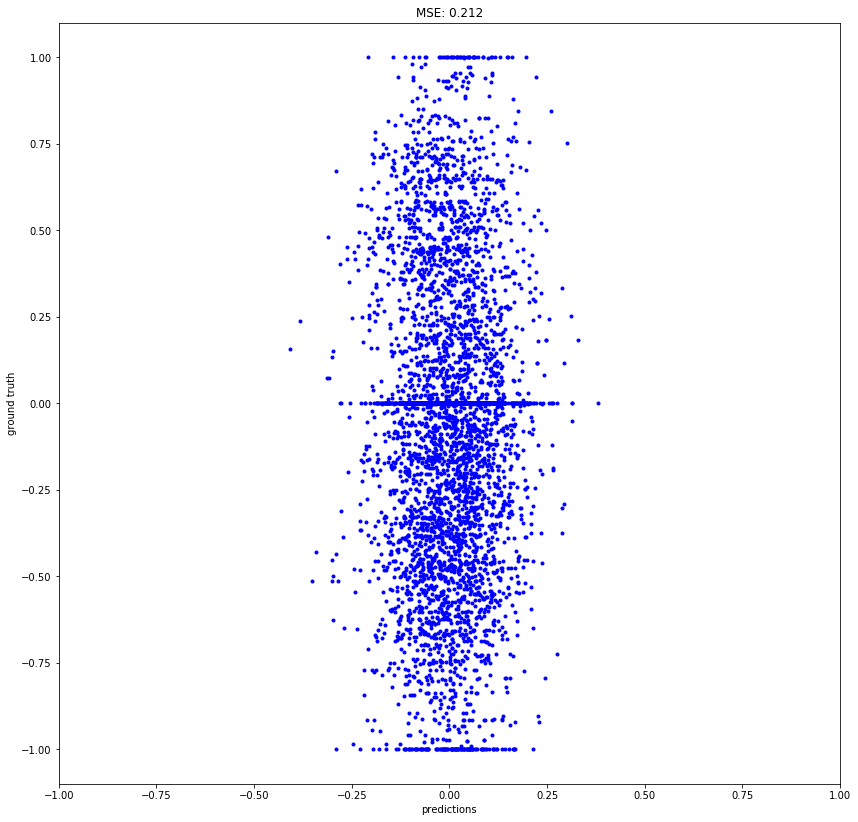

In [0]:
import matplotlib.pyplot as plt

def mean_squared_error(preds, true):
  squared_error = (true - preds)**2
  return np.mean(squared_error)

def xy_scatter(preds, truth):
    fig = plt.figure(figsize=(14,14))
    steering_p = preds[...,0]
    throttle_p = preds[...,1]
    steering_t = truth[...,0]
    throttle_t = truth[...,1]
    
    steering_mse = mean_squared_error(steering_p, steering_t)
    throttle_mse = mean_squared_error(throttle_p, throttle_t)
    plt.plot(steering_p, steering_t, 'b.')
    plt.title(f"MSE: {steering_mse:.3f}")
    plt.xlabel("predictions")
    plt.ylabel("ground truth")
    plt.gca().set_xlim(-1, 1)
    plt.show()
#     fig = plt.gcf()
#     fig.savefig(path + "/pred_vs_anno.png", dpi=100)

# Only display the validation set
xy_scatter(preds, truth)

In [0]:
preds = []
truth = []

for idx in tqdm(range(tub.get_num_records())):
    sample = tub.get_record(idx)
    pred = model.run(sample[IMAGE_KEY])
    preds.append(pred)
    truth.append((sample[STEERING_KEY], sample[THROTTLE_KEY]))
        
preds = np.array(preds)
truth = np.array(truth)
print(preds.shape) 


100%|██████████| 4462/4462 [00:23<00:00, 187.72it/s]

(4462, 2)


In [0]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [0]:

def plt_image(ax, image, title):
  ax.imshow(image)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)

def plt_samples(idxs, axs, tub):
  records = [tub.get_record(i) for i in idxs]
  images = [r[IMAGE_KEY] for r in records]
  titles = [f"frame: {i}" for i in idxs]
  for a,i,t in zip(axs, images, titles):
    plt_image(a,i,t)
        
def time_series(x=300):#, axs=axs, tub=tub):
  
    fig = plt.figure(figsize=(21,12))
    plt.tight_layout()

    ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=5)
    ax2 = plt.subplot2grid((2, 5), (1, 0))
    ax3 = plt.subplot2grid((2, 5), (1, 1))
    ax4 = plt.subplot2grid((2, 5), (1, 2))
    ax5 = plt.subplot2grid((2, 5), (1, 3))
    ax6 = plt.subplot2grid((2, 5), (1, 4))
    axs = [ax2, ax3, ax4, ax5, ax6]
    steering_p = preds[...,0]
    throttle_p = preds[...,1]
    steering_t = truth[...,0]
    throttle_t = truth[...,1]
  
    idxs = np.arange(x-2,x+3)
    plt_samples(idxs, axs, tub)
  
    start = x-300
    end  = x + 300
    ax1.plot(steering_p, label="predictions")
    ax1.plot(steering_t, label="ground truth")
    #ax1.axvline(x=x, linewidth=4, color='r')
    ax1.legend(bbox_to_anchor=(0.91, 0.96), loc=2, borderaxespad=0.)
    ax1.set_title("Time Series Throttle Predictions vs Ground Truth")
    ax1.set_xlabel("time (frames)")
    ax1.set_ylabel("steering command")
    ax1.set_xlim(start, end)
    
#time_series(x=600)
interact(time_series, x=(300, len(truth-300)))#, axs=fixed(axs), tub=fixed(tub))

interactive(children=(IntSlider(value=300, description='x', max=4462, min=300), Output()), _dom_classes=('widg…

<function __main__.time_series>

In [0]:
import numpy as np
import matplotlib.pyplot as plt    
testData = np.array([[0,0], [0.1, 0], [0, 0.3], [-0.4, 0], [0, -0.5]])
fig, ax = plt.subplots()
sctPlot, = ax.plot(testData[:,0], testData[:,1], "o", picker = 5)
plt.grid(True)
plt.axis([-0.5, 0.5, -0.5, 0.5])

def on_pick(event):
    artist = event.artist
    artist.set_color(np.random.random(3))
    print("click!")
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>